In [ ]:
import os
import random
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

In [42]:
# Create paths for saving images
project_root = os.path.dirname(os.getcwd()) # Go up one level from current directory i.e. notebooks folder to project root()
image_save_path = os.path.join(project_root, 'data', 'raw') # Path to save images

classes = ['Parasitized', 'Uninfected']
print('Data path:', image_save_path)

Data path: c:\Users\USER\LLMOPs_Projects\smart_malaria_detection_system\data\raw


Define Transformations

In [43]:
# preprocessing transforms for the images
''' Resizing, normalization, augmentation etc.
'''
IMAGE_SIZE = 150
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize images to 150x150
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to mean and std of 0.5 so that pixel values are between -1 and 1
])

Create Custom Dataset Class

In [44]:
class MalariaDataset(Dataset):
    
    def __init__(self, root_dir, classes, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for idx, cls in enumerate(classes):
            img_path = os.path.join(root_dir, cls)
            
            for img_name in os.listdir(img_path):
                self.image_paths.append(os.path.join(img_path, img_name)) # Save image path 
                self.labels.append(idx) # Save corresponding label index for the class
                
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB') # Open image and convert to RGB
        
        if self.transform:
            img = self.transform(img) # Apply transformations
            
        return img, label

Load Dataset & Inspect

In [45]:
# Load dataset
malaria_dataset = MalariaDataset(
    image_save_path,
    classes,
    transform
)
print('Total images in dataset:', len(malaria_dataset))

Total images in dataset: 27558


In [46]:
# Inspect a sample image from the dataset
img, label = malaria_dataset[0]
print(f'Image shape: {img.shape}')
print(f'Label: {label} ({classes[label]})')


Image shape: torch.Size([3, 150, 150])
Label: 0 (Parasitized)


Visualize Samples

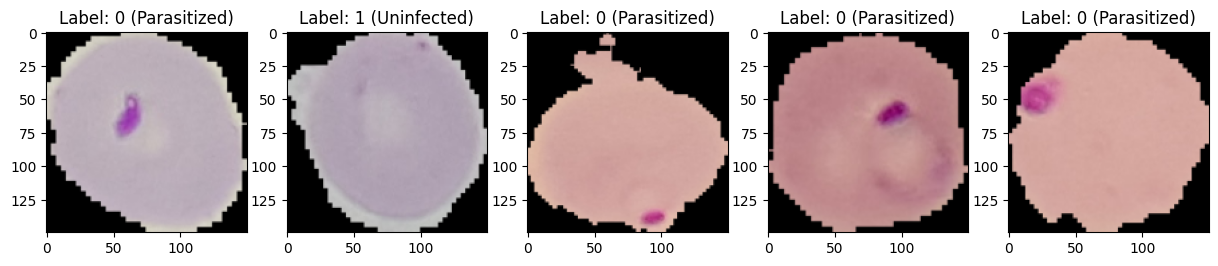

In [47]:
# Visualize the sample image

def show_image_sample(dataset, n = 5):
    
    plt.figure(figsize=(15, 5))
    
    for i in range(n):
        img, label = dataset[random.randint(0, len(dataset)-1)]
        img = img.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C) for plotting
        img = (img * 0.5) + 0.5  # Denormalize the image i.e. convert back to [0, 1] range
        plt.subplot(1, n, i + 1) # Create subplots i.e 1 row and n columns i+1  means position of the subplot from 1 to n
        plt.imshow(img)
        plt.title(f'Label: {label} ({classes[label]})')
    plt.show()
show_image_sample(malaria_dataset, n=5)

Data Augmentation

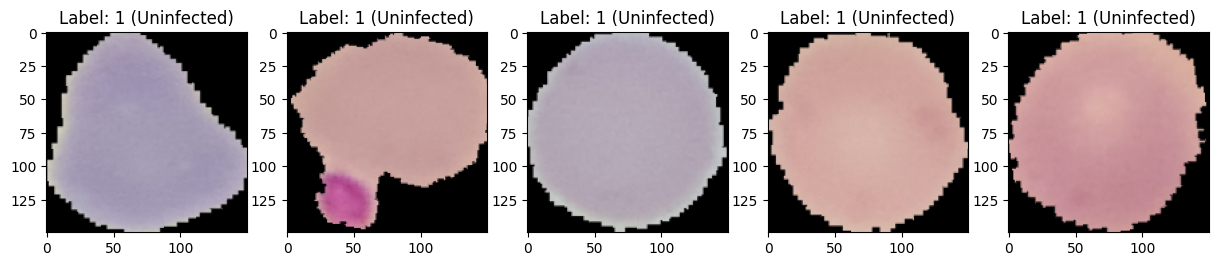

In [48]:
# Perform augmentation transforms and visualize
augment_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    ),
    transforms.ColorJitter()
])

augmented_dataset = MalariaDataset(
    image_save_path,
    classes,
    augment_transform
)

show_image_sample(augmented_dataset, n=5)              

Split data into training and test set

In [49]:
train_size = int(0.8 * len(malaria_dataset))
test_size = len(malaria_dataset) - train_size
train_dataset, test_dataset = random_split(malaria_dataset, [train_size, test_size])
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 22046
Test dataset size: 5512


Create DataLoader

In [50]:
batch_size = 32
train_loder = DataLoader(
    dataset=malaria_dataset,
    batch_size=batch_size,
    shuffle=True
)

images, labels = next(iter(train_loder)) # Get a batch of images and labels, next(iter()) gets the first batch from the dataloader i.e
print(f'Batch image tensor shape: {images.shape}')  # Should be (batch_size, 3, IMAGE_SIZE, IMAGE_SIZE)
print(f'Batch labels tensor shape: {labels.shape}')  # Should be (batch_size,)
print(f'Labels in batch: {labels}')

Batch image tensor shape: torch.Size([32, 3, 150, 150])
Batch labels tensor shape: torch.Size([32])
Labels in batch: tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 0])


In [51]:
from torch.utils.data import DataLoader

# Create DataLoader
batch_size = 32
train_loader = DataLoader(malaria_dataset, batch_size=batch_size, shuffle=True)

# Get the first 4 batches
for i, (images, labels) in enumerate(train_loader):
    if i >= 4:
        break
    print(f"Batch {i+1}")
    print("Images shape:", images.shape)
    print("Labels:", labels)


Batch 1
Images shape: torch.Size([32, 3, 150, 150])
Labels: tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0])
Batch 2
Images shape: torch.Size([32, 3, 150, 150])
Labels: tensor([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1])
Batch 3
Images shape: torch.Size([32, 3, 150, 150])
Labels: tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0])
Batch 4
Images shape: torch.Size([32, 3, 150, 150])
Labels: tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0])


Saving Batch 5 --> to c:\Users\USER\LLMOPs_Projects\smart_malaria_detection_system\notebooks\unnormalized_batch_images
Batch 1
Images shape: torch.Size([32, 3, 150, 150])
Labels: tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0])


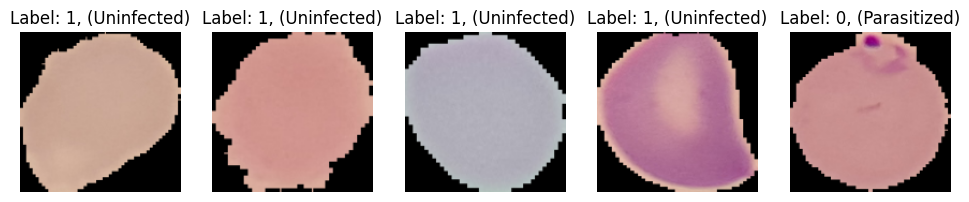

Batch 2
Images shape: torch.Size([32, 3, 150, 150])
Labels: tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1])


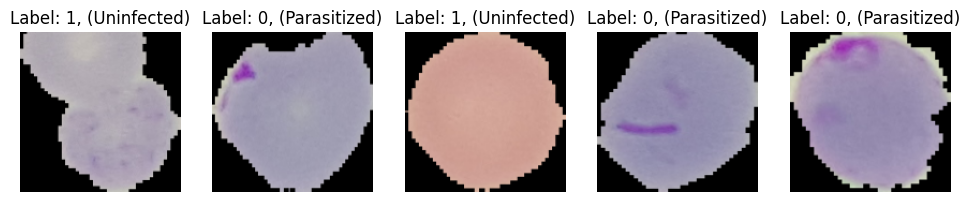

Batch 3
Images shape: torch.Size([32, 3, 150, 150])
Labels: tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 0])


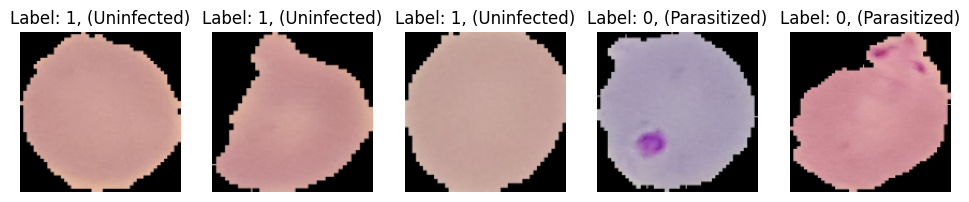

Batch 4
Images shape: torch.Size([32, 3, 150, 150])
Labels: tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 0])


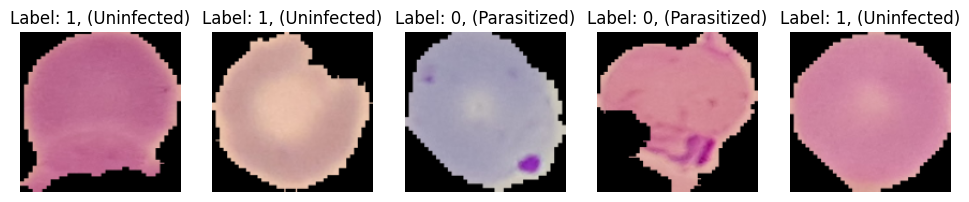

In [52]:
from torchvision import transforms

# Create DataLoader
batch_size = 32
train_loader = DataLoader(malaria_dataset, batch_size=batch_size, shuffle=True)

# Helper to unnormalize and convert tensor to PIL
to_pil = transforms.ToPILImage()

# Save the batch images and labels
save_batch_image = os.path.join(os.getcwd(), 'unnormalized_batch_images') # Save in notebooks folder
os.makedirs(save_batch_image, exist_ok=True) 

print(f'Saving Batch {i+1} --> to {save_batch_image}')

# Loop through first 4 batches
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print("Images shape:", images.shape)
    print("Labels:", labels[:10])  # show first 10 labels
    
    # Visualize first 5 images in the batch
    plt.figure(figsize=(12,3)) # 12 width, 3 height
    for j in range(5):
        # Undo normalization: [-1,1] → [0,1]
        unnormalized = images[j] * 0.5 + 0.5
        
        # Save unnormalized image
        label_name = classes[labels[j]]
        img_pil = to_pil(unnormalized)
        img_pil.save(os.path.join(save_batch_image, f'{label_name}_batch{i+1}_img{j+1}.png'))
        
        plt.subplot(1,5,j+1)
        plt.imshow(to_pil(unnormalized))
        plt.title(f'Label: {labels[j]}, ({classes[labels[j]]})')
        plt.axis("off")
    plt.show()
    
    if i == 3:  # stop after 4 batches
        break


Save Preprocessed Dataset

In [53]:
torch.save(train_dataset, 'train_dataset.pt')
torch.save(test_dataset, 'test_dataset.pt')